In [1]:
%%capture
!pip install pydna
!pip install teemi
!pip install matplotlib
!pip install seaborn
!pip install Bio
!pip install intermine

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 01_1_DESIGN_Promoters

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/01_1_DESIGN_Promoters.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [3]:
!git clone https://github.com/hiyama341/G8H_CPR_library.git

fatal: destination path 'G8H_CPR_library' already exists and is not an empty directory.


## 1. Intro

Promoters are a major component of protein expression and are a key driver of biological systems (Kotopka & Smolke, 2020). To make a library with diversity and unique expression levels and kinetics I want to look for characteristics such as:  

- High/low constitutive expression
- Increase/decrease in expression over time.

**We want to automate and standardize the selection process with an algorithm**

**About the Data used here**:
Selection can be automated from RNA-seq data, where mRNAs are sequenced, mapped to specific genes, and added to a count matrix. It is important to note that this method could be modified and applied to other data sets or organisms.
In S. cerevisiae, promoters are defined as the 1kb upstream of the transcriptional start site (TSS)(a lab standard) and therefore make them easy to retrieve. The RNA-seq data used here was generated by Arun et al (Rajkumar et al., 2019) and the data is composed of three columns representing time points i.e samples taken at 6 hours, 12, hours and 24 hours. The 6303 rows represent the genes of S. cerevisiae and each has RNA counts for each of the time points. 

### 1.1 **The algorithm/method for finding the set of promoters we're interesed is described as follows:**

1. Load in RNA-seq data
2. Pre-process the data i.e sort, remove irrelevant data points(zero counts), and set a lower limit for what is considered low-expression, etc. 
3. Consider what expression dynamics are interesting and search through the pre-processed data
4. Save best candidates in each group of expression dynamics.
5. Retrieve the sequences of these (Upstream sequences of TSS) from the sequence database. 
6. Align the sequences to avoid homology. 
7. Choose the best candidates based on homology and expression dynamics
8. Chosen promoters should be saved and exported as FASTA (to an external database). 


## 2. Data-processing

First step in this workflow is to read the RNAseq data in. 

In [4]:
df = pd.read_csv('G8H_CPR_library/data/01-promoters/RNA_seq_data/RNAseq_reads_arun.csv', index_col=0)

In [5]:
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W-B,0.000000,0.000000,0.000000
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
...,...,...,...
tV(UAC)Q,0.000000,0.000000,0.000000
COX3,0.122102,0.153141,0.155030
tM(CAU)Q2,0.000000,0.000000,0.000000


Then we can sort all values

In [6]:
df.sort_values(by=['NIL_6h_FPKM'], ascending = False)

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219
...,...,...,...
tD(GUC)J3,0.00,0.00,0.000
tR(UCU)J2,0.00,0.00,0.000
EMT5,0.00,0.00,0.000


It turns out we have a many of genes that do not have any counts in the dataset. We are not interested in these genes since they are most likely controlled by inducible promoters so we filter them out. 

### 2.1 Removing zeros from the dataset

In [7]:
df = df.loc[~(df==0).all(axis=1)]
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
BDH1,169.859000,43.289800,282.497000
...,...,...,...
21S_RRNA,0.240608,0.261625,0.234314
SCEI,0.091711,0.000000,0.000000
COX2,0.031348,0.000000,0.000000


After filtering all the genes out that were only zero, I notice that there are still some genes with close to zero counts but we will deal with that later. Lets plot the data. 

### 2.2 Gene-expression profiles of S. cerevisiae

In [8]:
from teemi.learn.plotting import bar_plot
bar_plot

<function teemi.learn.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


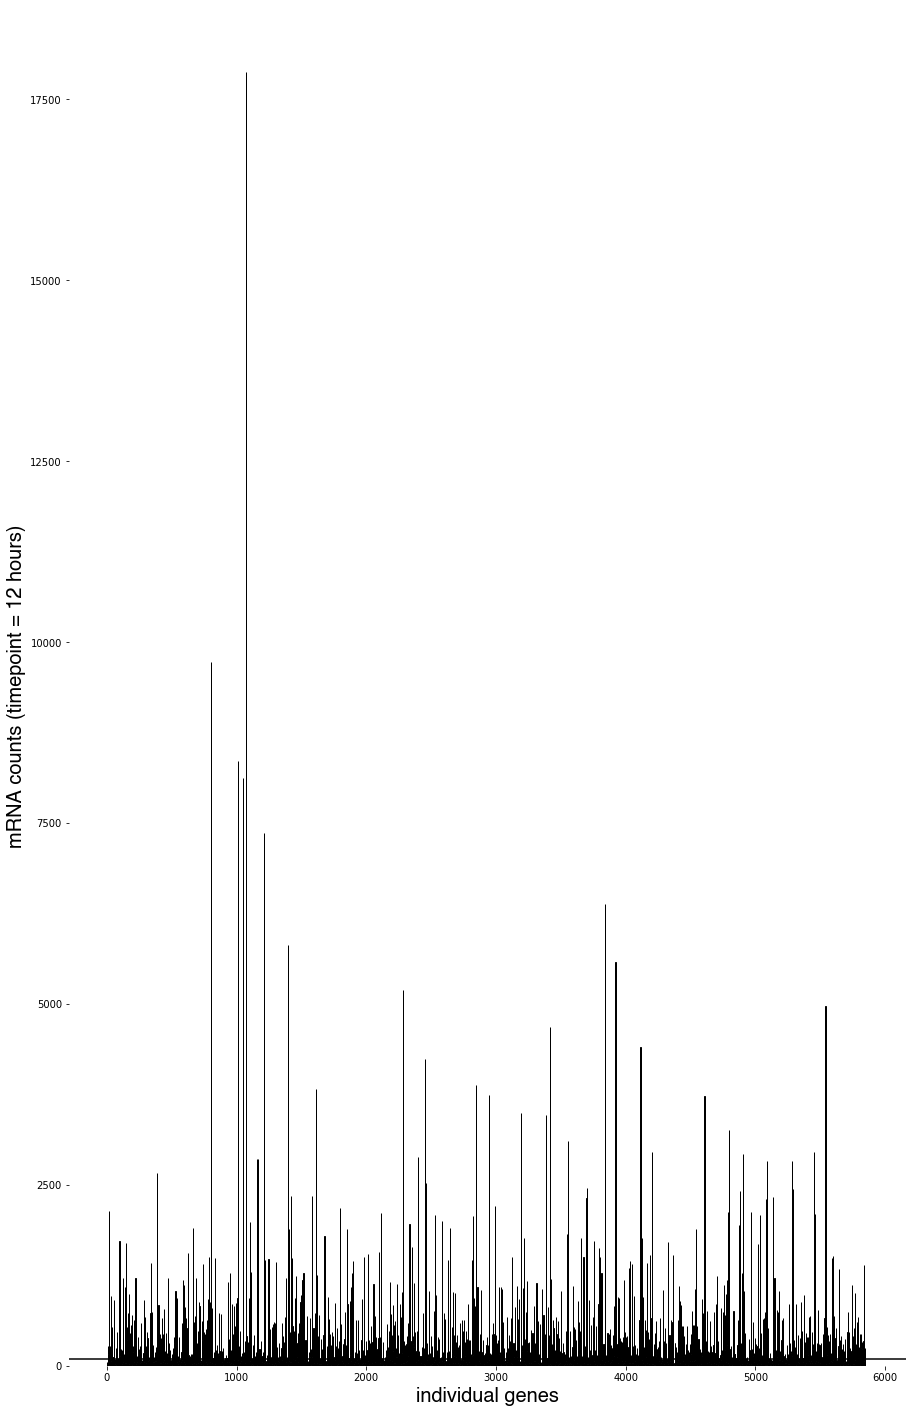

In [9]:
x = [i for i in range(0,len(df))]
y = df['NIL_12h_FPKM'].to_list()
bar_plot(x, y, path= 'G8H_CPR_library/data/10-plots/01_1_DESIGN_Promoters/gene_expression_profiles_s_cerevisiae.pdf',
        x_label = 'individual genes', 
         y_label = 'mRNA counts (timepoint = 12 hours)'
        )

Previously, we made a large overview of all the expression profiles in S. cerevisiae. To view them follow the link : [Expression profiles in S. cerevisiae](../colab_notebooks/G8H_CPR_library/data/10-plots/01_1_DESIGN_Promoters/gene_expression_profiles_s_cerevisiae.pdf.pdf) .

**Notes:**

The plotted data shows us that there are approximately 20 genes that at some point in during the have RNA counts of >5000. Most other genes are found to have < 1000 counts.  

Additionally, as we saw before quite a lot of data points have RNA counts close to zero and as we are not interested in promoters that do not express anyhting. They can be filtered out. 

**Setting an expression threshold:**

I choose to put a threshold expression level - arbitrarily chosen and can differ from dataset to dataset. Genes with counts less than 2000 counts combined from all timepoints were filtered out.  


In [10]:
threshold = 640
df_with_threshold = df[df['NIL_6h_FPKM']+ df['NIL_12h_FPKM']+ df['NIL_24h_FPKM'] > threshold]
df_with_threshold

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL044W-A,245.231,267.378,274.042
CDC19,1632.650,2142.150,101.161
SNC1,279.743,290.354,321.153
EFB1,1088.300,970.904,487.837
ADE1,884.882,542.645,1367.400
...,...,...,...
RPC40,293.395,433.721,152.376
ANT1,215.003,274.217,205.789
YPR148C,291.884,334.582,314.950


This step filtered out most of the genes with 1089 remaining promoters. With this amount of promoters let's look at the dynamics in a line-diagram to get an understanding how they increase or decrease over time

Sorting the values of the dataframe

In [11]:
df_with_threshold = df_with_threshold.sort_values(by=['NIL_6h_FPKM', 'NIL_12h_FPKM', 'NIL_24h_FPKM'], ascending = False)
df_with_threshold.head()

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219


### 2.3 Selecting the top 15 promoters in each category (HIGH/LOW constitutive expression) to perform an alignment

We can pick 15 genes with the highest counts and 15 genes with lowest counts and make them into a list

In [12]:
# Selecting top15
List_of_Top15_High_constitutive_prom = df_with_threshold[:15]
List_of_Top15_Low_constitutive_prom = df_with_threshold[-15:] 

# making them into a list
List_of_Top15_High_constitutive_promoters = List_of_Top15_High_constitutive_prom.index.values.tolist() 
List_of_Top15_Low_constitutive_promoters = List_of_Top15_Low_constitutive_prom.index.values.tolist()

In [13]:
print(List_of_Top15_High_constitutive_promoters)
print(List_of_Top15_Low_constitutive_promoters)

['RPL41B', 'SPO24', 'YDR524W-A', 'RPL41A', 'TDH3', 'CCW12', 'SED1', 'ICL1', 'FBA1', 'YBR085C-A', 'YDR134C', 'YOR302W', 'NCE103', 'SNZ1', 'RPL39']
['MRPL10', 'YBR016W', 'NFU1', 'TIP1', 'AIM7', 'GPA1', 'AUA1', 'DAK1', 'RPL15B', 'ATG8', 'GID8', 'IRC23', 'YJR154W', 'ICL2', 'YAR035C-A']


Now, as we have a lot experience and have the promoter CYC1 and URE2 available, it will be added to the list of constitutive HIGH expression and constritutuve LOW expression promoters respectively.


In [14]:
List_of_Top15_High_constitutive_promoters.append('CYC1')
List_of_Top15_Low_constitutive_promoters.append('URE2')

### 2.4 Selecting the top 15 promoters in each category (DECREASING expression) to perform an alignment
We can look for genes that have the highest/increase increase relative to the first timepoint.

We can investigate genes that have show the greatets difference in counts from 6 hour to 24 hour

We can pick these dynamics by:
    
1. Find genes were expression increase from 6 - 24 hour timepoint in mRNA counts 
    - This method is good at capturing decreases in expression 
2. Do the same but where we calculate the relative increase (in %) from first to last timepoint. 
    - This method is good at capturing increases in expression 
    - Poor at getting decreases because the relative points will only go to -1 and doestnt capture steep decreases. See table below: 
    
    
    
    
|                      | 6 hour | 24 hour  | % diff relative to first timepoint |   |
|----------------------|--------|----------|------------------------------------|---|
| mRNA counts - gene x | 5000   | 50       | -0.99                             |   |
| mRNA counts - gene y | 100    | 1        | -0.99                             |   |
|                      |        |          |                                    |   |    

With this in mind we mix the methods by picking INCREASING promoters with relative increase in & and pick DECREASING promoters with mRNA count differences. 

Getting the one that has the steepest decrease in expression and steepest increase in expression with the pandas idmax function

In [15]:
print((df_with_threshold['NIL_6h_FPKM'] - df_with_threshold['NIL_24h_FPKM']).idxmax())
print((df_with_threshold['NIL_24h_FPKM'] - df_with_threshold['NIL_6h_FPKM']).idxmax())

TDH3
ICL1


Find difference from first column to the last column: 


In [16]:
# Lets only look at the difference between 6 and 24 hour.
df_with_DIFF_over_time_increasing = df_with_threshold[['NIL_6h_FPKM','NIL_24h_FPKM']]

In [17]:
# Find the difference between the columns
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.diff(axis='columns')

# Sort the dataframe
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.sort_values(by=['NIL_24h_FPKM' ], ascending = False)

# # df_with_change_over_time
df_with_DIFF_over_time_increasing.tail()

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
RPL41A,NaN,-3531.720
SED1,NaN,-3574.680
FBA1,NaN,-3636.760
RPL41B,NaN,-3652.300
TDH3,NaN,-4778.581


### 2.5 Selecting the top 15 promoters in each category (INCREASING expression) to perform an alignment


In [18]:
df_with_change_over_time = df_with_threshold.pct_change(axis='columns')
df_with_change_over_time_increasing = df_with_change_over_time.sort_values(by=[ 'NIL_12h_FPKM','NIL_24h_FPKM' ], ascending = True)

# df_with_change_over_time
df_with_change_over_time_increasing

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709
...,...,...,...
RIB4,NaN,0.906627,-0.870206
MET28,NaN,0.948386,-0.849363
PRM5,NaN,0.959731,-0.843176


KEEP in mind that it only is relative to the adjacent timepoint and not the first timepoint. The top and botton can be picked from the dataframe: 


In [19]:
# Selecting top5
Top15_increasing_promoters = df_with_change_over_time_increasing[:15]
Top15_decreasing_promoters = df_with_DIFF_over_time_increasing[-15:]

# Making it into a list 
List_of_Top15_increasing_promoters = Top15_increasing_promoters.index.values.tolist() 
List_of_Top15_descreasing_promoters = Top15_decreasing_promoters.index.values.tolist()
print(List_of_Top15_increasing_promoters)
print(List_of_Top15_descreasing_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2', 'IDP2', 'ACS1', 'ICL1', 'REG2', 'SPG4', 'HXT5', 'YGR067C', 'JEN1', 'YNR034W-A', 'ACH1']
['RPS28A', 'RPL10', 'RPS30B', 'TPI1', 'RPS30A', 'YDR524W-A', 'ENO2', 'CCW12', 'GPM1', 'RPL39', 'RPL41A', 'SED1', 'FBA1', 'RPL41B', 'TDH3']


In [20]:
all_promoters_we_have_found = List_of_Top15_High_constitutive_promoters + List_of_Top15_Low_constitutive_promoters + List_of_Top15_increasing_promoters+ List_of_Top15_descreasing_promoters

In [21]:
len(all_promoters_we_have_found)

62

## 3. Fetching promoter sequences with Intermine

#### 3.1 We can now fetch the 1kb upstream of these promoters with the following fucntions directly from intermines databases:  

In [22]:
print(List_of_Top15_increasing_promoters)
print(List_of_Top15_descreasing_promoters)

print(List_of_Top15_High_constitutive_promoters)
print(List_of_Top15_Low_constitutive_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2', 'IDP2', 'ACS1', 'ICL1', 'REG2', 'SPG4', 'HXT5', 'YGR067C', 'JEN1', 'YNR034W-A', 'ACH1']
['RPS28A', 'RPL10', 'RPS30B', 'TPI1', 'RPS30A', 'YDR524W-A', 'ENO2', 'CCW12', 'GPM1', 'RPL39', 'RPL41A', 'SED1', 'FBA1', 'RPL41B', 'TDH3']
['RPL41B', 'SPO24', 'YDR524W-A', 'RPL41A', 'TDH3', 'CCW12', 'SED1', 'ICL1', 'FBA1', 'YBR085C-A', 'YDR134C', 'YOR302W', 'NCE103', 'SNZ1', 'RPL39', 'CYC1']
['MRPL10', 'YBR016W', 'NFU1', 'TIP1', 'AIM7', 'GPA1', 'AUA1', 'DAK1', 'RPL15B', 'ATG8', 'GID8', 'IRC23', 'YJR154W', 'ICL2', 'YAR035C-A', 'URE2']


Here the function "FetchMultiplePromoters" is just applied to each of the lists of promoters

In [23]:
from teemi.design.fetch_sequences import fetch_multiple_promoters

In [24]:
%%time
Indcreasing_promoters = fetch_multiple_promoters(List_of_Top15_increasing_promoters)
Decreasing_promoters = fetch_multiple_promoters(List_of_Top15_descreasing_promoters)

High_constitutive_promoters = fetch_multiple_promoters(List_of_Top15_High_constitutive_promoters)
Low_constitutive_promoters = fetch_multiple_promoters(List_of_Top15_Low_constitutive_promoters)

CPU times: user 7.83 s, sys: 515 ms, total: 8.35 s
Wall time: 10min 31s


In [25]:
Decreasing_promoters[0]

SeqRecord(seq=Seq('TTGTGGGTTTTCACCCACTTTATGCAAATCACCTAGGAAACCTTCATTGAACAT...ATC'), id='RPS28A', name='RPS28A Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[])

In [26]:
Indcreasing_promoters[0].name

'YAR035C-A Promoter'

In [27]:
High_constitutive_promoters[0].name

'RPL41B Promoter'

In [28]:
Low_constitutive_promoters[4].id

'AIM7'

## 4. Check for Homology between promoters with multiple sequence alingment 

In [29]:
from Bio.Align import MultipleSeqAlignment
All_promoters = Indcreasing_promoters + Decreasing_promoters + High_constitutive_promoters + Low_constitutive_promoters

align = MultipleSeqAlignment(All_promoters)
for record in align:
    print(record.seq[0:100] + " " + record.id)# print(align.substitutions)

CCCTGGTGGCCCTTTCCAATAGTTTTTTCAGTTCGATGTCGATGGCGATCTTGGTGTTGGTGGCGGTGTCGTTTTCATTGACTTTCCTAACGAGCTCGAT YAR035C-A
TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTAAAACCATGAGGCTTCTTCAAAATGAAATAACTCTCTCTCGACACTC MLS1
ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGAGAGTGCCAGCGAACCGCGTCTTTCCCCTCGCCGCTTTAACTACGTA PCK1
CCGGTGGTGCTTATACTGTTTCTACTGCAGCTGCCGCTACTGTTAGATCTACCATCAGAAGATTAAGAGAAATGGTTGAAGCTTAAACTTCTTTCATTCA SFC1
ACCTTGGGATATCGTTGGAAATCCTAACCATCGGCATAATTTTTGAAGACTTGAATAACTCCATAATATTAAGCGTGCTGGTGCTTTTGGGCTCACTACT ADY2
AATAGTCTTACACCAATGAGCCAAATAGTGAATGCGGTCCTGAACCAGAACGAGACTGTTACGTTCGCAGCAAGAGGCCATGTCCTTGAAGATGGTATAG IDP2
AAGTGGTCTGCAAATGCTTTGCAGACGCCGGAGTAGTGTCGTTTGTGTCAGAGGAACGTGCTGTACCGCTGCACAGTACGAAACACGTTAAAAGGCACCT ACS1
TGGAAATGTAAAGGATAATGAGTGAGCATATAAAATGGAAGAAAAAATAATAATAGGATTATGTATAAAATATCGATTCCCTTTTGTAGATTTCGAGATC ICL1
GGAAAAGAGGCAGCCAAAGTCGCCAAAACTAATGCAGATTTTTCCTATAAAATCCTAACAAGAGAAACGTTGGTTGAGTACGATTACTACTTATTCGGAA REG2
AGGAGTCTTATGTGACAGCACTTGCGTTATTGTCAGCCGGA

With biopython it is possible to align sequences in what is termed a "DUMMY ALIGNMENT" - see below

In [30]:
from Bio.Align import AlignInfo
summary_align = AlignInfo.SummaryInfo(align)
gap_consensus = summary_align.gap_consensus()
consensus = summary_align.dumb_consensus( threshold=0.7)
print(consensus)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAXX

In [31]:
counter = 0
for nucleotide in consensus: 
    if nucleotide != 'X': 
        counter += 1
        
print('Amount of consensus with a 70% threshold: ', (counter/len(consensus))*100, '%')
print('Nucleotides that are the same at a 70% threshold:', counter)

Amount of consensus with a 70% threshold:  0.1 %
Nucleotides that are the same at a 70% threshold: 1


From these results we dont see any long stretches of homology which intuitively makes sense because then S. cerevisiaes would loop out constantly. 

Another way of showing if the sequences are homologous is to use other online tools. 
One of these toos is to use the Mview online tool: https://www.ebi.ac.uk/Tools/msa/mview/
 
You just simply upload the fasta file with all sequences

1. From the list of promoters we want to choose 4 promoters that are as different as possible and we want to choose 1 from each group for 2 set of promoters. 


First i'm gonna retrieve the names of the promoters

In [32]:
all_promoter_names = []
for names in All_promoters:
    all_promoter_names.append(names.id)

### 4.1 Dynamics of the promoters after first filtering step: 
    

Then take them out from the above dataframe

In [33]:
df_with_selected_promoters = df_with_threshold.loc[all_promoter_names]
df_with_selected_promoters.columns =[6, 12, 24]
df_with_selected_promoters.head(10)

,6,12,24
gene_short_name,,,
YAR035C-A,143.259,0.00000,548.738
MLS1,2222.160,8.09464,5267.000
PCK1,1948.900,9.80902,4639.410
SFC1,911.584,10.49830,2218.090
ADY2,412.787,5.09830,1021.810
IDP2,463.841,6.12787,1101.780
ACS1,530.982,7.11924,1270.950
ICL1,5044.520,82.05450,11968.600
REG2,326.784,6.52391,797.242


Lets remove any promoter that have zero counts in any of the columns: 

In [34]:
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[6] > 0]
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[12] > 0]
df_with_selected_promoters = df_with_selected_promoters[df_with_selected_promoters[24] > 0]

Adding categories to the selected promoters 

In [35]:
df_with_selected_promoters['category'] = ''
for index, row in df_with_selected_promoters.iterrows():

    if index in List_of_Top15_increasing_promoters: 
        df_with_selected_promoters.at[index,'category']='Increasing'

    if index in List_of_Top15_descreasing_promoters: 
        df_with_selected_promoters.at[index,'category']='Decreasing'
        
    if index in List_of_Top15_High_constitutive_promoters:
        df_with_selected_promoters.at[index,'category']='High constitutive'

    if index in List_of_Top15_Low_constitutive_promoters: 
        df_with_selected_promoters.at[index,'category']='Low constitutive'
df_with_selected_promoters

,6,12,24,category
gene_short_name,,,,
MLS1,2222.160,8.09464,5267.0000,Increasing
PCK1,1948.900,9.80902,4639.4100,Increasing
SFC1,911.584,10.49830,2218.0900,Increasing
ADY2,412.787,5.09830,1021.8100,Increasing
IDP2,463.841,6.12787,1101.7800,Increasing
ACS1,530.982,7.11924,1270.9500,Increasing
ICL1,5044.520,82.05450,11968.6000,High constitutive
REG2,326.784,6.52391,797.2420,Increasing
SPG4,1224.760,24.83530,2916.6900,Increasing


The next exercise is to narrow the search down to only 8 promoters which will be covered in the next section. 

## 5. Final selection of promoters:

### 5.1 Picking HIGH constitutive promoters: 

As mentioned earlier in the notebook the CYC1 promoter is well studied and we want to use that as one of the high constitutive promoters. For the second choice, RPL41B and SPO24 have an extrodinary high mRNA counts that could potentially put too much burden on the host strain so we will exlude those.

In [36]:
List_of_Top15_High_constitutive_prom.head()

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219


If we look at the next 5 candidates we notice that some of them have been used in previous studies namely TDH3 and CCW12 (https://academic.oup.com/nar/article/45/1/496/2572058). These two are both active in the exponential phase but TDH drops considerably at the 24 hour mark. Therefore, to ensure more stable expression the CCW12 was chosen as second promoter. 




In [37]:
pHIGH_constitutive = ['CYC1', 'CCW12']

### 5.2 Picking LOW constitutive promoters: 

For the low constitutive we were again using our knowledge of which promoters have worked in the lab and here the URE2 promoter was chosen as one of the low constitutive promoters.

In [38]:
List_of_Top15_Low_constitutive_prom = List_of_Top15_Low_constitutive_prom.sort_values(by=['NIL_6h_FPKM'], ascending = True)
List_of_Top15_Low_constitutive_prom.head()

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,143.259,0.0000,548.738
ICL2,190.041,20.4447,435.158
YJR154W,195.600,242.9640,210.320
IRC23,196.792,222.5550,232.621
GID8,198.447,54.5051,408.253


For the second of the low constitutive promoter we are not interested in an sudden drop or increase in  expression and we will therfore drop those ('YAR035C-A', 'ICL2', 'GID8'). Then we have very similar characteristics for the next five promoters and a literature search did not come out fruitful. Arbitrarily the RPL15B promoter was chosen. 


In [39]:
# NON-stable promoters
non_stable_promoters = ['YAR035C-A', 'ICL2', 'GID8']

Updated_Low_constitutive_prom = List_of_Top15_Low_constitutive_prom.drop(non_stable_promoters)

Updated_Low_constitutive_prom[:5].sort_values(by=['NIL_6h_FPKM'], ascending = True)

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YJR154W,195.600,242.964,210.320
IRC23,196.792,222.555,232.621
ATG8,199.029,172.542,282.057
RPL15B,200.212,186.509,258.028
DAK1,200.626,234.508,205.936


In [40]:
pLOW_constitutive = ['RPL15B', 'URE2']

### 5.3 Picking INCREASING promoters: 


Examining the top15 increasing promoters we find that the top promoter increases infinite and which is due to the fact that the previous datapoint is zero. We will remove this as a top candidate and look at the following promoters. Here we see that by far the best candidates are MLS1 and PCK1 and since these are also know from literature it is an easy pick for the increasing promoters.

In [41]:
Top15_increasing_promoters

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709
IDP2,NaN,-0.986789,178.798201
ACS1,NaN,-0.986592,177.523269
ICL1,NaN,-0.983734,144.861592
REG2,NaN,-0.980036,121.203096


In [42]:
pINCREASING = ['PCK1', 'MLS1']

### 5.4 Picking DECREASING promoters: 


In [43]:
Top15_decreasing_promoters = Top15_decreasing_promoters.sort_values(by=['NIL_24h_FPKM'], ascending = True)
Top15_decreasing_promoters.head()

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
TDH3,NaN,-4778.581
RPL41B,NaN,-3652.300
FBA1,NaN,-3636.760
SED1,NaN,-3574.680
RPL41A,NaN,-3531.720


For the decreasings promoters one thing becomes clear and that is that many of what are considered strong constitutive promoters are found to be in the top, namely TDH3 (http://parts.igem.org/Part:BBa_K124002, https://academic.oup.com/nar/article/45/1/496/2572058). Additionally, the promoter we chose as one of the high constitutive promoters can be found in thin the top 8 (CCW12). As we are not interested in the high constitutive promoters for this category we well cutoff after CCW12. 


In [44]:
Decreasing_promoters = Top15_decreasing_promoters[8:]
Decreasing_promoters

,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
ENO2,NaN,-2865.8586
YDR524W-A,NaN,-2219.1100
RPS30A,NaN,-2168.9100
TPI1,NaN,-2055.6160
RPS30B,NaN,-1919.9100
RPL10,NaN,-1716.1800
RPS28A,NaN,-1685.1020


Examining this list and cross-referencing with literature the promoters ENO2 and TPI1 are well know from the litterature (https://academic.oup.com/nar/article/45/1/496/2572058, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4480987/) and have been shown to work well in yeast systems. Additionally, the referenced papers also support that the promoters show the pattern of decreasing expression over time. ENO2 and TPI1 are good candidates for this category.

In [45]:
pDECREASING = ['ENO2', 'TPI1']

## 6. Plotting chosen promoters

In [46]:
chosen_promoters = [pHIGH_constitutive, pLOW_constitutive, pINCREASING, pDECREASING]
promoters1, promoters2 = list(), list()

# Taking one promoter from each nested list
for i in range(len(chosen_promoters)):
    promoters1.append(chosen_promoters[i][0])
    promoters2.append(chosen_promoters[i][1])  
print(promoters1)
print(promoters2)

['CYC1', 'RPL15B', 'PCK1', 'ENO2']
['CCW12', 'URE2', 'MLS1', 'TPI1']


 Lets add the reference promotors to the plot

In [47]:
G8H_reference_promoters = ['TDH3']
CPR_reference_promoters = ['TEF1']

promoters1 = promoters1+ G8H_reference_promoters
promoters2 = promoters2+ CPR_reference_promoters
promoters2

['CCW12', 'URE2', 'MLS1', 'TPI1', 'TEF1']

In [48]:
legend1_names = ['p'+name for name in promoters1]
legend2_names = ['p'+name for name in promoters2]
legend2_names

['pCCW12', 'pURE2', 'pMLS1', 'pTPI1', 'pTEF1']

In [49]:
df_with_prom1 = df_with_threshold.loc[promoters1].transpose()
df_with_prom1.index = [6, 12, 24]
df_with_prom2 = df_with_threshold.loc[promoters2].transpose()
df_with_prom2.index = [6, 12, 24]

In [50]:
df_with_prom1

gene_short_name,CYC1,RPL15B,PCK1,ENO2,TDH3
6,2775.83,200.212,1948.90000,2950.2200,5623.800
12,3742.74,186.509,9.80902,2527.2700,5198.450
24,2459.66,258.028,4639.41000,84.3614,845.219


In [51]:
df_with_prom2

gene_short_name,CCW12,URE2,MLS1,TPI1,TEF1
6,5496.46,253.590,2222.16000,2264.780,510.931
12,6376.54,344.076,8.09464,2853.860,420.244
24,2516.05,222.439,5267.00000,209.164,320.136


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1095/2955520707.py:38: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)


<Figure size 432x288 with 0 Axes>

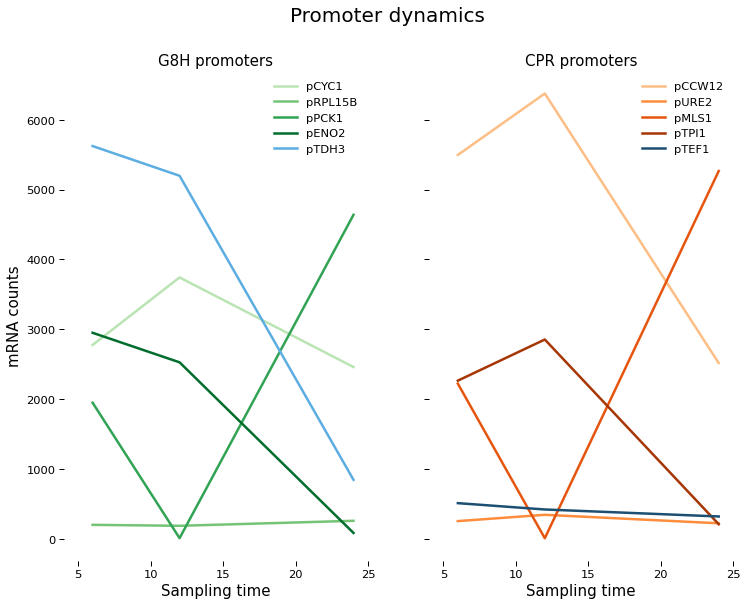

In [52]:
# Plotting an empty subplot
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c', '#5cade2']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603', '#1c4f72']

import seaborn as sns
#set seaborn plotting aesthetics as default
#sns.set_style("white")
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.despine(bottom = True, left = True)

# Plotting an empty subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,9), sharey=True)  # 1 row, 2 columns 

# Adding the DFs
ax1 = df_with_prom1.plot( ax=ax1, color = pg8H_color )
ax2 = df_with_prom2.plot( ax=ax2, color = pcpr_color)


# Fixing legend names # removes the borders around the plot
sns.despine(bottom = True, left = True)
ax1.legend(legend1_names, frameon=False)
ax2.legend(legend2_names, frameon=False)

# changing the range of the x axis
ax1.set_xlim(4,25)
ax2.set_xlim(4,25)

# Adding all the titles
ax1.set_title("G8H promoters",  fontsize=15)
ax2.set_title("CPR promoters",  fontsize=15)
fig.suptitle("Promoter dynamics", fontsize=20)
ax1.set_ylabel("mRNA counts",  fontsize=15)
ax1.set_xlabel("Sampling time", fontsize=15)
ax2.set_ylabel("mRNA counts",  fontsize=15)
ax2.set_xlabel("Sampling time", fontsize=15)

# Getting shared axes
ax1.get_shared_x_axes().join(ax1, ax2)
plt.savefig('G8H_CPR_library/data/10-plots/01_1_DESIGN_Promoters/Dynamics_of_chosen_promoters.pdf',format = 'pdf', dpi = 300)


#### 6.1 Retrieving first set of promoters from all of the promoters

In [53]:
Promoters_for_fasta = []
for i in range(0, len(All_promoters)): 
    for j in range(0, len(promoters1)): 
        if All_promoters[i].id == promoters1[j]: 
            Promoters_for_fasta.append(All_promoters[i])
# TDH3 appear twice so lets remove that (it appeared in two different lists)
Promoters_for_fasta.pop(2)
Promoters_for_fasta

[SeqRecord(seq=Seq('ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGA...AAC'), id='PCK1', name='PCK1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='ENO2', name='ENO2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('CTATTTTCGAGGACCTTGTCACCTTGAGCCCAAGAGAGCCAAGATTTAAATTTT...AAA'), id='TDH3', name='TDH3 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('GAGGCACCAGCGTCAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAG...ATA'), id='CYC1', name='CYC1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGCGGAAGCGGAAGTGGAAGTACTGCTGGCCATTTTTATTCAGGTTATTTGCG...GCA'), id='RPL15B', name='RPL15B Promot

#### 6.2 Retrieving second set of promoters from all of the promoters

In [54]:
Promoters_for_fasta1 = []
for i in range(len(All_promoters)): 
    for j in range(len(promoters2)): 
        if All_promoters[i].id == promoters2[j]:
            Promoters_for_fasta1.append(All_promoters[i])

# CCW12 appear twice so lets remove that (it appeared in two different lists)
Promoters_for_fasta1.pop(2)
Promoters_for_fasta1

[SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='MLS1', name='MLS1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='TPI1', name='TPI1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AACCAGGGCAAAGCAAAATAAAAGAAACTTAATACGTTATGCCGTAATGAAGGG...ATA'), id='CCW12', name='CCW12 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGACGAA...CAA'), id='URE2', name='URE2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched through Intermines API', dbxrefs=[])]

## 7. Exporting the sequemces as FASTA file 

In [55]:
with open('G8H_CPR_library/data/01-promoters/promoter_sequences/Promoter_sequences_1.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta)):
        print(Promoters_for_fasta[i].format("fasta"), file = outfile)

In [56]:
with open('G8H_CPR_library/data/01-promoters/promoter_sequences/Promoter_sequences_2.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta1)):
        print(Promoters_for_fasta1[i].format("fasta"), file = outfile)

## 8. MSA of promoters

We can asses homology with different tools and one of them is  https://www.ebi.ac.uk/Tools/msa/clustalo/


After running an sequence alignment the following result was obtained: 



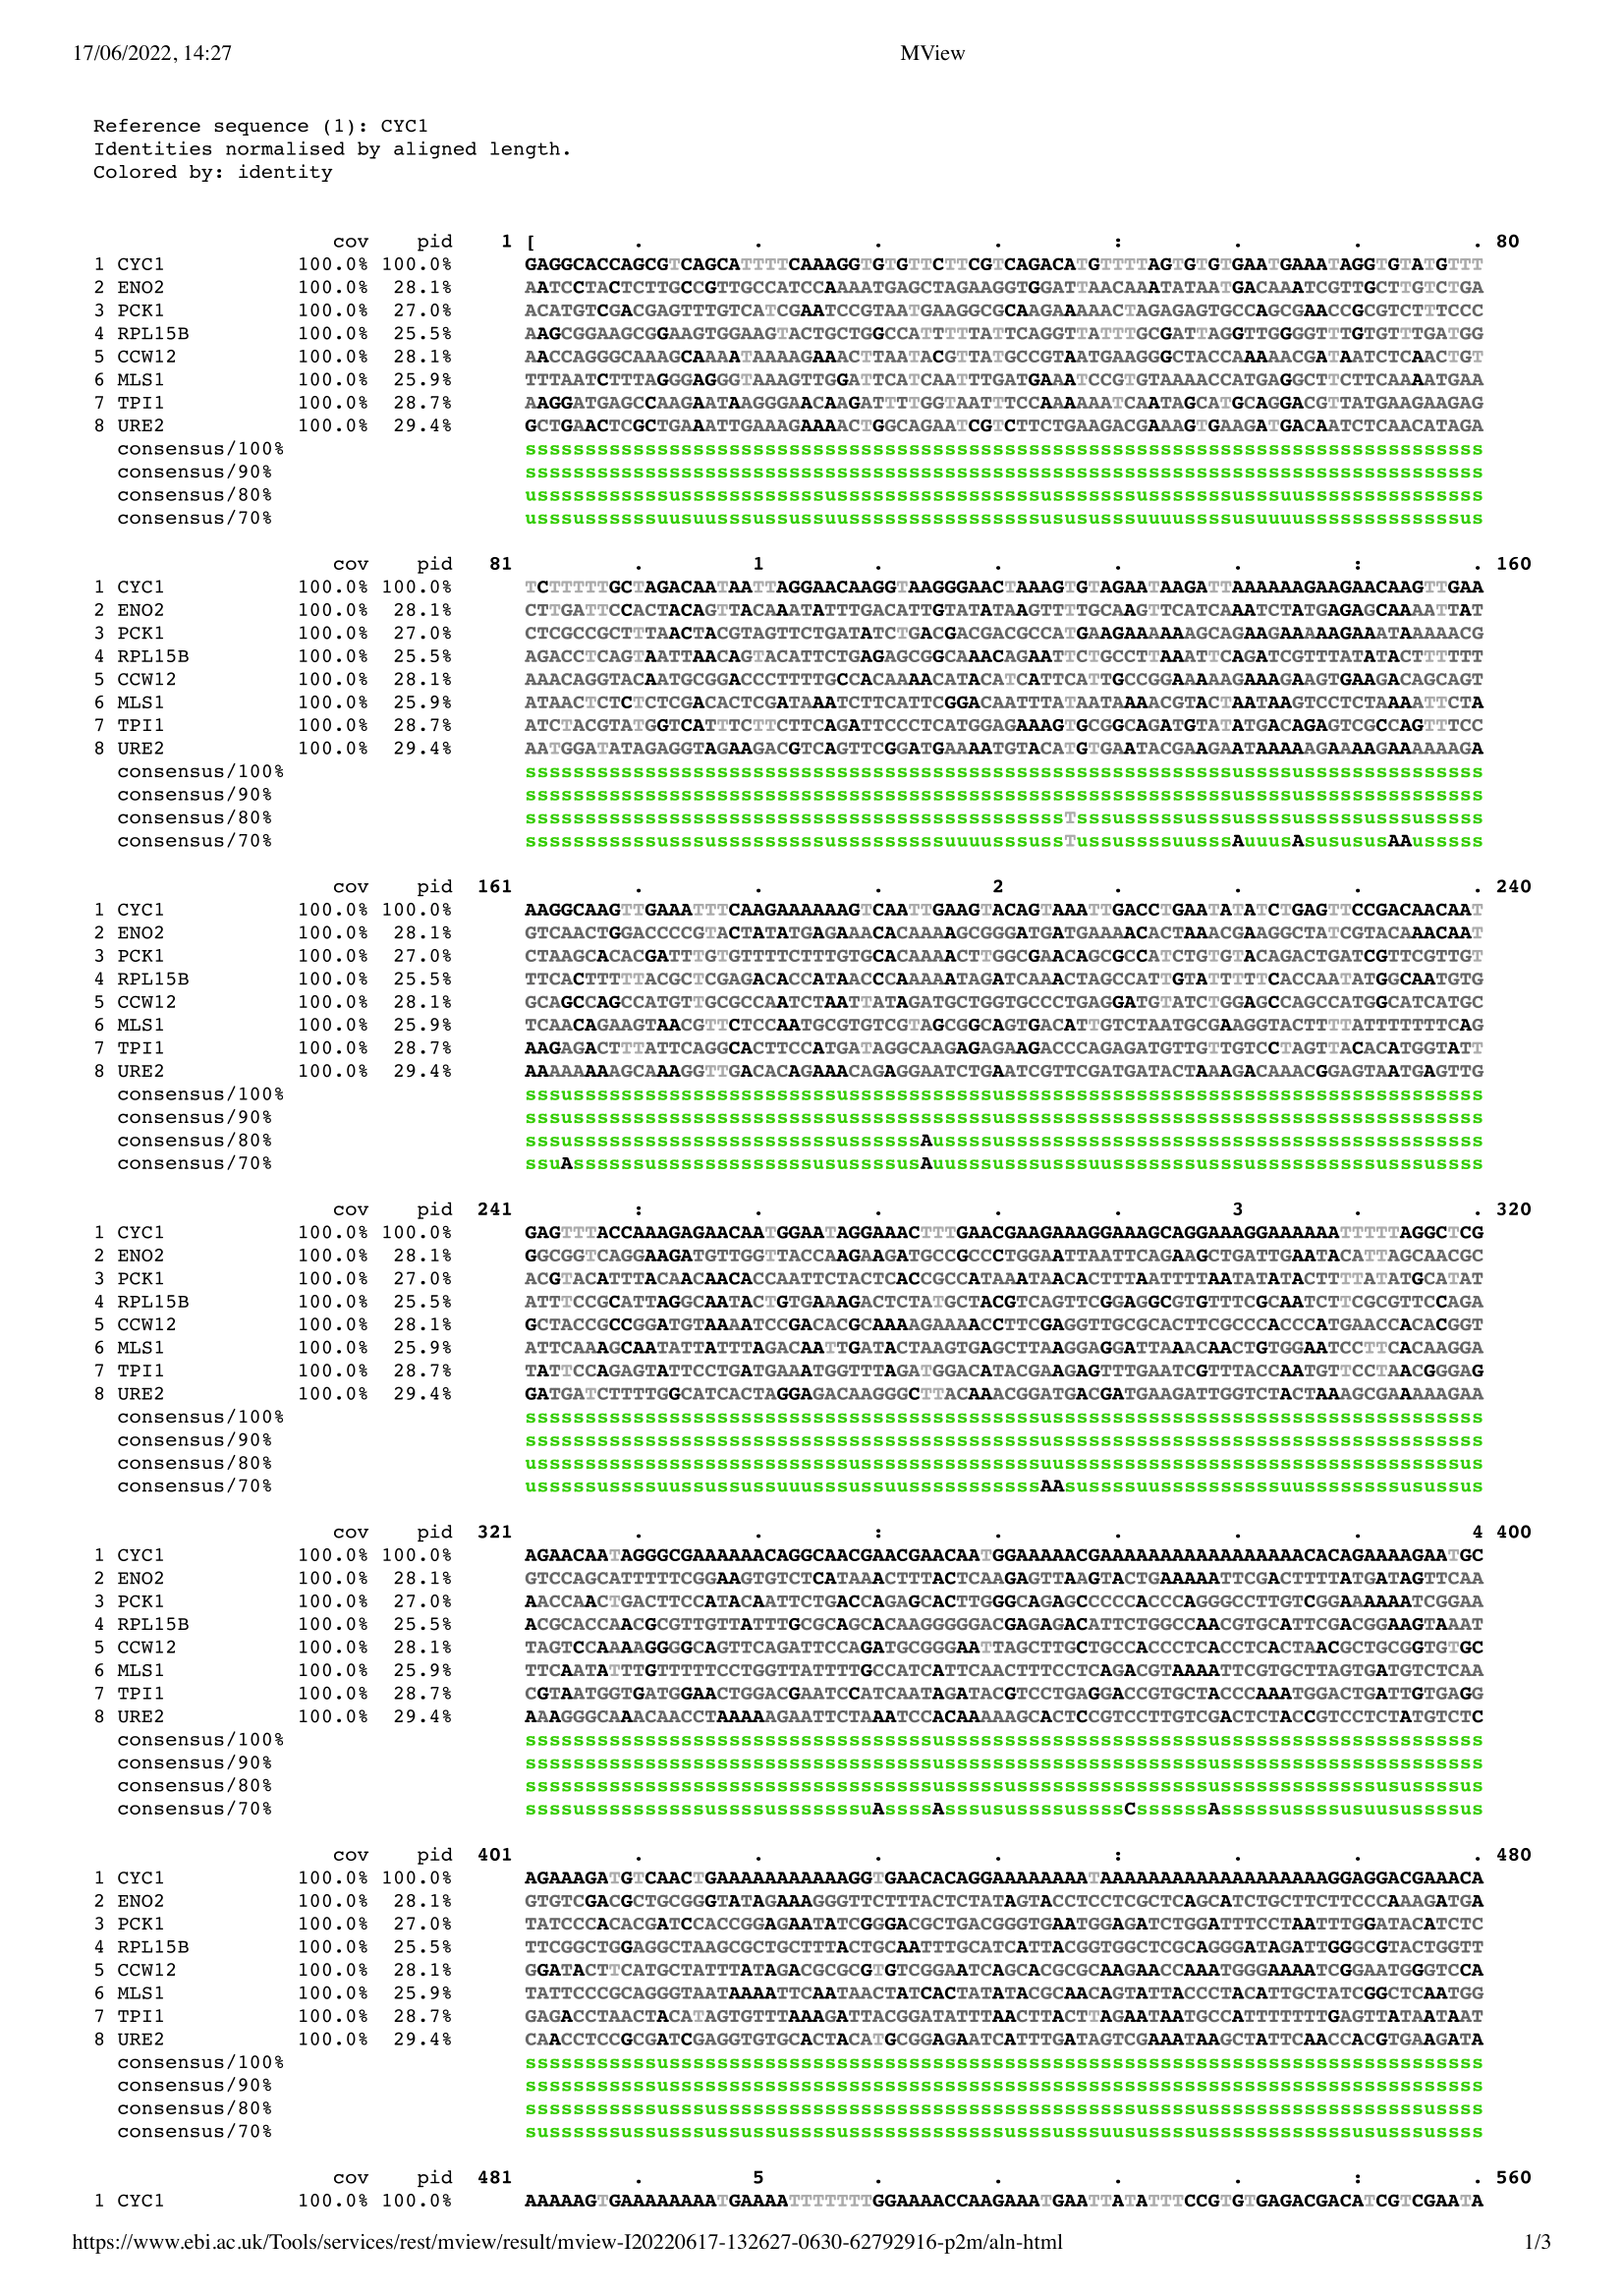

In [57]:
import IPython
IPython.core.display.Image('G8H_CPR_library/data/01-promoters/promoter_homology/Promoters_homology-1.png', width=800)

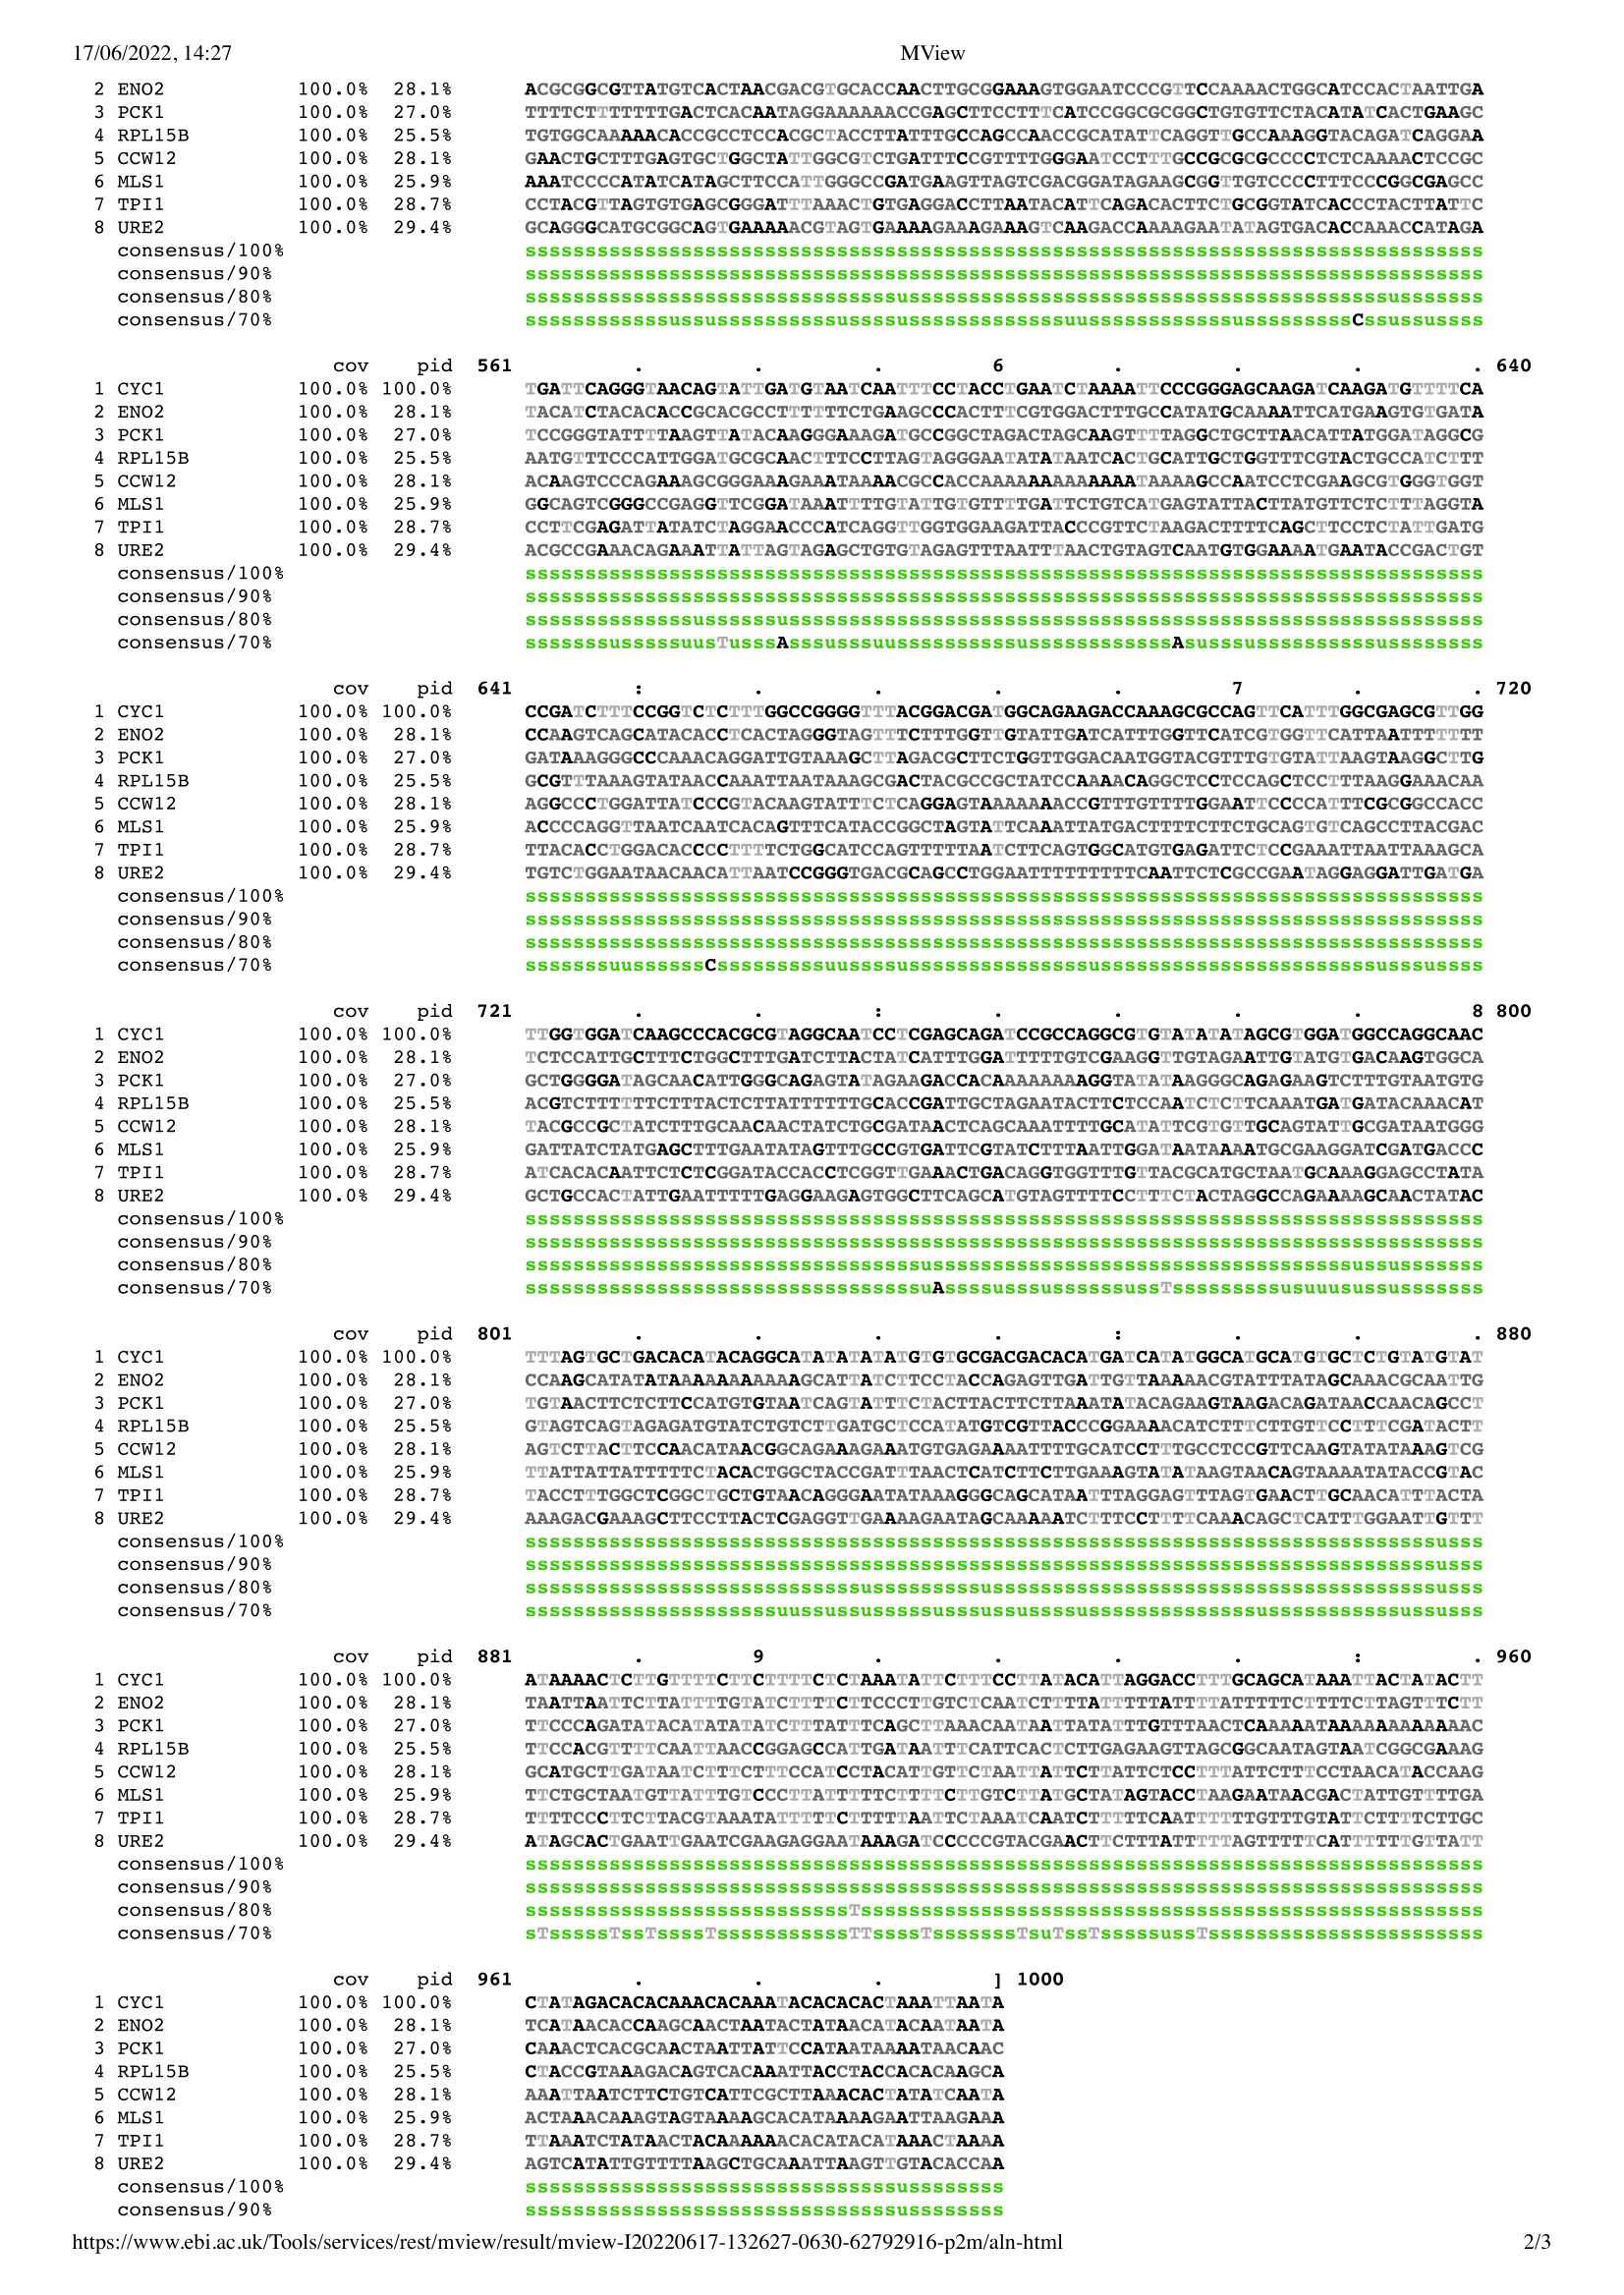

In [58]:
IPython.core.display.Image('G8H_CPR_library/data/01-promoters/promoter_homology/Promoters_homology-2.png', width=800)

# Refences 

Kotopka, B. and Smolke, C., 2020. Model-driven generation of artificial yeast promoters. Nature Communications, 11(1).

Rajkumar, A., Özdemir, E., Lis, A., Schneider, K., Qin, J., Jensen, M. and Keasling, J., 2019. Engineered Reversal of Function in Glycolytic Yeast Promoters. ACS Synthetic Biology, 8(6), pp.1462-1468.